In [19]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
from matplotlib import pyplot as plt

# Import the algorithms and metrics

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score,
    accuracy_score,
)

from utilities import get_arxiv_articles

In [20]:
# We import the data
all_df = pd.read_csv("data/zotero_data.csv")
all_df.columns

Index(['Ind', 'authors', 'title', 'year', 'is_cited_own_paper',
       'is_of_interest'],
      dtype='object')

First we compare the year-on-year distribution of interesting and random papers. The papers I use and cite all crowd towards the late 2010s or early 2020s. This matches research either published since the start of my career or research most relevant to my own.

<Axes: xlabel='year', ylabel='Count'>

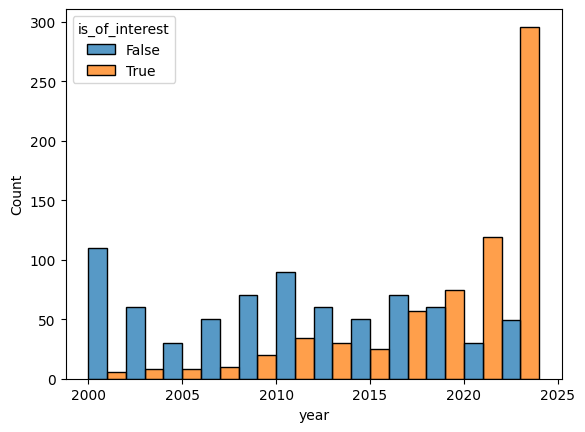

In [21]:
sns.histplot(
    data=all_df, x="year", multiple="dodge", hue="is_of_interest", binrange=(2000, 2024)
)

Now we will use this dataset containing both papers reflecting my interests and random papers. In this first attempt we only use the titles as feature which we first vectorize using Term Frequency–Inverse Document Frequency.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

all_titles = list(all_df["title"])
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(all_df["title"])  # Build vocabulary from all the titles
y = all_df["is_of_interest"]

We first separate our dataset into a training dataset and a test dataset. We will compare three methods here: KNeighbors Classifier, Logistic Regression and Random Forest Classifier. We will evaluate these methods with both F1 metric and simple accuracy metric.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=5
)

names = [
    "kNN",
    "log_reg",
    # "bayes",
    "forest",
]
methods = [
    KNeighborsClassifier(),
    LogisticRegression(),
    # GaussianNB(),
    RandomForestClassifier(),
]


def compare_model(name, model):
    pred = model.fit(X_train, y_train)
    pred_result = pred.predict(X_test)
    f1 = f1_score(y_test, pred_result, average="macro")
    acc = accuracy_score(y_test, pred_result)
    return {"name": name, "f1": f1, "acc": acc, "pred": pred}


comparison = [compare_model(*args) for args in zip(names, methods)]
for c in comparison:
    print(f"Model {c['name']}: f1 is {c['f1']} and accuracy is {c['acc']}")

Model kNN: f1 is 0.7578147175702525 and accuracy is 0.7620041753653445
Model log_reg: f1 is 0.8115096715519956 and accuracy is 0.8121085594989561
Model forest: f1 is 0.7814320814320814 and accuracy is 0.7828810020876826


We see all methods are quite good but with roughly equivalent results, around 80% of correctness. Since the logistic regression method is slightly above the two others, we will focus on it.

In [24]:
pred_log = comparison[1]["pred"]

Let us start with some random recent hep-th papers, see whether the quantitative agreement measured by those metrics actually translate into a qualitative (subjective) agreement.

In [25]:
# rnd_sample_hepth = get_arxiv_articles("hep-th", 8, 2023)
# rnd_titles = [x["title"].replace("\n", "") for x in rnd_sample]
# Hard-coded result for reproducibility
rnd_titles_hepth = [
    "Renormalization of spin-one asymptotic charges in AdS$_D$",
    "Tunneling to Holographic Traversable Wormholes",
    "Supersymmetric Cardy Formula and the Weak Gravity Conjecture in AdS/CFT",
    "Dense Geodesics, Tower Alignment, and the Sharpened Distance Conjecture",
    "AdS$_3$ Pure Gravity and Stringy Unitarity",
    "Long-term Oscillations and Universal Behavior in Pulsed Electric Fields",
    "String Field Theory",
    "Prescriptive Unitarity from Positive Geometries",
    "What can be measured asymptotically?",
    "The Signum-Gordon shock waves in 2+1 and 3+1 dimensions",
]
display(rnd_titles_hepth)

rnd_titles_hepth_subjective = [
    True,
    True,
    True,
    False,
    False,
    False,
    True,
    False,
    True,
    False,
]

['Renormalization of spin-one asymptotic charges in AdS$_D$',
 'Tunneling to Holographic Traversable Wormholes',
 'Supersymmetric Cardy Formula and the Weak Gravity Conjecture in AdS/CFT',
 'Dense Geodesics, Tower Alignment, and the Sharpened Distance Conjecture',
 'AdS$_3$ Pure Gravity and Stringy Unitarity',
 'Long-term Oscillations and Universal Behavior in Pulsed Electric Fields',
 'String Field Theory',
 'Prescriptive Unitarity from Positive Geometries',
 'What can be measured asymptotically?',
 'The Signum-Gordon shock waves in 2+1 and 3+1 dimensions']

We now run the vectorizer and Logistic Regression prediction on this set. We then compare it to the subjective assessment. Over this tiny sample, the success rate is only 60% but this is not surprising. The possible reasons for lack of accuracy are the following:

1. This is a small sample, our metrics were only around 85% so 60% is not that far off on a small sample.
2. The dataset is a bit skewed: the training and test data for the `is_of_interest` negative case is random papers not in my library. This of course does not account for lack of accurage of my library: there can be many many papers in this category which could or should have been in my library.

In [26]:
rnd_titles_hepth_tfidf = vectorizer.transform(rnd_titles_hepth)
rnd_titles_hepth_pred = pred_log.predict(rnd_titles_hepth_tfidf)
display(rnd_titles_hepth_pred)

[x[0] == x[1] for x in zip(rnd_titles_hepth_subjective, rnd_titles_hepth_pred)].count(
    True
) / len(rnd_titles_hepth)

array([False,  True, False, False, False, False,  True,  True, False,
       False])

0.6

Now we made a copy of the dataset and manually edited the random entries to mark them as `is_of_interest` if they would have made the to_read list. Let us see if this improves the results.

In [28]:
# We import the data
edited_df = pd.read_csv("data/zotero_data_edited.csv")
edited_df.columns

Index(['Ind', 'authors', 'title', 'year', 'is_cited_own_paper',
       'is_of_interest'],
      dtype='object')

In [33]:
y_edited = edited_df["is_of_interest"]

In [34]:
X_train, X_test, y_edited_train, y_edited_test = train_test_split(
    X, y_edited, test_size=0.33, random_state=5
)


def compare_model_edited(name, model):
    pred = model.fit(X_train, y_edited_train)
    pred_result = pred.predict(X_test)
    f1 = f1_score(y_edited_test, pred_result, average="macro")
    acc = accuracy_score(y_edited_test, pred_result)
    return {"name": name, "f1": f1, "acc": acc, "pred": pred}


comparison_edited = [compare_model_edited(*args) for args in zip(names, methods)]
for c in comparison_edited:
    print(f"Model {c['name']}: f1 is {c['f1']} and accuracy is {c['acc']}")

Model kNN: f1 is 0.7451099122903593 and accuracy is 0.7578288100208769
Model log_reg: f1 is 0.846733437068531 and accuracy is 0.8475991649269311
Model forest: f1 is 0.8052717854566913 and accuracy is 0.8058455114822547


We see the various metrics are higher than in the previous case! What about the subjective comparison?

In [35]:
pred_log_edited = comparison_edited[1]["pred"]
rnd_titles_hepth_tfidf_edited = vectorizer.transform(rnd_titles_hepth)
rnd_titles_hepth_pred_edited = pred_log_edited.predict(rnd_titles_hepth_tfidf_edited)
display(rnd_titles_hepth_pred_edited)

[
    x[0] == x[1] for x in zip(rnd_titles_hepth_subjective, rnd_titles_hepth_pred_edited)
].count(True) / len(rnd_titles_hepth)

array([False,  True, False, False,  True, False,  True,  True, False,
       False])

0.5

Somehow it is worse, but once again the subjective test on a sample of 10 titles is not a very representative measure.

# PCA

In [42]:
from sklearn.decomposition import PCA
from nltk.tokenize.casual import casual_tokenize

In [46]:
vectorizer_title_casual = TfidfVectorizer(tokenizer=casual_tokenize)
vectorizer_title_casual.fit(raw_documents=edited_df["title"])

vectorizer_authors_casual = TfidfVectorizer(tokenizer=casual_tokenize)
vectorizer_authors_casual.fit(edited_df["authors"])

title_tfidf = vectorizer_title_casual.transform(edited_df["title"]).toarray()
authors_tfidf = vectorizer_authors_casual.transform(edited_df["authors"]).toarray()

/home/nchagnet/pyenvs/zoteroML_py/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


We do a PCA analysis with two components

In [60]:
pca = PCA(n_components=2)
title_pca = pca.fit_transform(title_tfidf)

edited_df_pca_title = pd.DataFrame(title_pca, index=edited_df["is_of_interest"])
edited_df_pca_title.columns = ["pca1", "pca2"]

<Axes: xlabel='pca1', ylabel='pca2'>

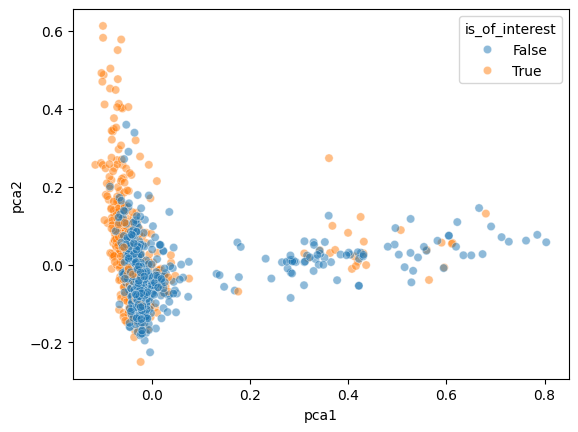

In [61]:
sns.scatterplot(
    edited_df_pca_title, x="pca1", y="pca2", hue="is_of_interest", alpha=0.5
)

In [62]:
pca2 = PCA(n_components=2)
authors_pca = pca2.fit_transform(authors_tfidf)

edited_df_pca_authors = pd.DataFrame(authors_pca, index=edited_df["is_of_interest"])
edited_df_pca_authors.columns = ["pca1", "pca2"]

<Axes: xlabel='pca1', ylabel='pca2'>

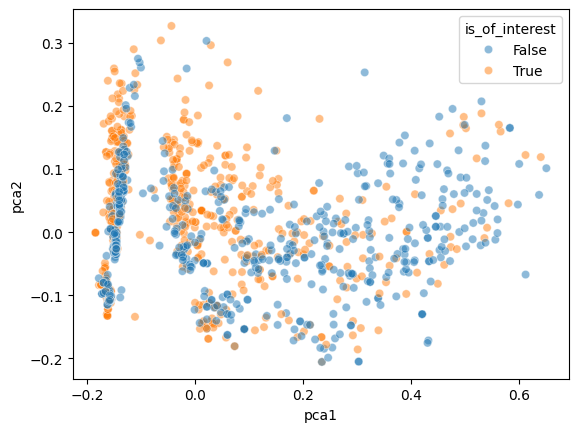

In [63]:
sns.scatterplot(
    edited_df_pca_authors, x="pca1", y="pca2", hue="is_of_interest", alpha=0.5
)